# Valid Topologies

In [4]:
import os.path
import time
import random
import csv
import array
import math
import numpy as np
import pandas as pd
import scipy
import scipy.io
from joblib import Parallel, delayed
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypower.api import ext2int, int2ext, makeYbus
from itertools import combinations

class ValidTopology:
    def __init__(self, path, test_case, switchable_lines, max_switch_off=3):
        self.PATH = path
        self.TEST_CASE = test_case
        self.switchable_lines = switchable_lines
        self.max_switch_off = max_switch_off
        self.mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
        self.branch = self.mat['ans']['branch'][0][0]
        self.branch_status = self.branch[:, 10]
        self.switchable_on = [line for line in self.switchable_lines if self.branch_status[line] == 1]
        self.switchable_off = [line for line in self.switchable_lines if self.branch_status[line] == 0]

    def generate_topologies(self):
        topologies = [(tuple(), tuple(), self.branch_status.copy())]  # Base topology with no lines switched on/off
        for r in range(1, self.max_switch_off + 1):
            for off_comb in combinations(self.switchable_on, r):
                for on_comb in combinations(self.switchable_off, r):
                    new_branch_status = self.branch_status.copy()
                    for line in off_comb:
                        new_branch_status[line] = 0
                    for line in on_comb:
                        new_branch_status[line] = 1
                    topologies.append((off_comb, on_comb, new_branch_status))
        return topologies

    def process_bus_and_gen(self, bus, gen, baseMVA, branch, ppc):
        Just_load = bus[np.logical_or(bus[:, 2] != 0, bus[:, 3] != 0)]
        load_buses = Just_load[:, 0]
        load_buses = np.reshape(load_buses, (len(load_buses), 1))
        n_buses = len(ppc['bus'])
        n_gens = len(ppc['gen'])
        n_branches = len(ppc['branch'])
        r = branch[:, 2]
        x = branch[:, 3]
        ref_bus = np.where(bus[:, 1] == 3)[0][0]
        return load_buses, n_buses, n_gens, n_branches, r, x, ref_bus

    def compute_incidence_matrix(self, n_buses, n_branches, branch, ref_bus):
        """Compute the incidence matrix"""
        A = np.zeros((n_buses, n_branches))
        from_bus = branch[:, 0].astype(int)
        to_bus = branch[:, 1].astype(int)
        A[from_bus, np.arange(n_branches)] = 1
        A[to_bus, np.arange(n_branches)] = -1
        A = np.delete(A, ref_bus, axis=0)
        A = A.T
        return A

    def load_data(self, baseMVA):
        """Load the Voltage solutions"""
        AC_DATA = pd.read_csv(f"{self.PATH}/results/Voltage_AC_uniform_{self.TEST_CASE}bus.txt", sep=',')
        df = pd.DataFrame(AC_DATA, columns=['i', 'Vm', 'Va'])
        V_AC = df.Vm
        theta_AC = df.Va
        return V_AC, theta_AC

    def validate_topologies(self):
        topologies = self.generate_topologies()
        valid_topologies = []  # Initialize an empty list for valid topologies

        for topology in topologies:
            mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
            bus = mat['ans']['bus'][0][0]
            baseMVA = mat['ans']['baseMVA'][0][0][0][0]
            gen = mat['ans']['gen'][0][0]
            branch = mat['ans']['branch'][0][0]

            # Update branch[:,10] based on the current topology
            _, _, topology_branch_status = topology
            branch[:, 10] = topology_branch_status

            keys = ['baseMVA', 'bus', 'gen', 'branch']
            values = [baseMVA, bus, gen, branch]
            ppc = dict(zip(keys, values))
            ppc = ext2int(ppc)
            baseMVA, bus, gen, branch = ppc['baseMVA'], ppc['bus'], ppc['gen'], ppc['branch']

            load_buses, n_buses, n_gens, n_branches, r, x, ref_bus = self.process_bus_and_gen(bus, gen, baseMVA, branch, ppc)
            V_AC, theta_AC = self.load_data(baseMVA)
            A = self.compute_incidence_matrix(n_buses, n_branches, branch, ref_bus)

            # Attempt to compute F and skip topology if singular
            try:
                F = np.linalg.inv(A)
                valid_topologies.append(topology)  # Add this topology to the list of valid topologies
            except np.linalg.LinAlgError:
                print("Skipping singular topology")
                continue  # Skip the rest of the loop for this topology

        return valid_topologies

    def save_valid_topologies(self, valid_topologies):
        file_path = f"{self.PATH}/Topology studies/parameters/Valid_Topologies.npy"
        np.save(file_path, np.array(valid_topologies, dtype=object))

if __name__ == "__main__":
    switchable_lines = [3, 9, 25, 32, 33, 34, 35, 36]
    power_system = ValidTopology('/Users/babaktaheri/Desktop/OLDF/Single-phase', '33', switchable_lines)
    valid_topologies = power_system.validate_topologies()
    power_system.save_valid_topologies(valid_topologies)


Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology
Skipping singular topology


# Training

In [ ]:
import os.path
import time
import random
import numpy as np
import pandas as pd
import scipy.io
from joblib import Parallel, delayed
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypower.api import ext2int, int2ext, makeYbus
from itertools import combinations

class TopologyTraining:
    def __init__(self, path, test_case, optimization_method):
        self.PATH = path
        self.TEST_CASE = test_case
        self.OPTIMIZATION_METHOD = optimization_method
        self.topologies = None

    def process_bus_and_gen(self, bus, gen, baseMVA, branch, ppc):
        Just_load = bus[np.logical_or(bus[:, 2] != 0, bus[:, 3] != 0)]
        load_buses = Just_load[:, 0]
        load_buses = np.reshape(load_buses, (len(load_buses), 1))
        n_buses = len(ppc['bus'])
        n_gens = len(ppc['gen'])
        n_branches = len(ppc['branch'])
        r = branch[:, 2]
        x = branch[:, 3]
        ref_bus = np.where(bus[:, 1] == 3)[0][0]
        return load_buses, n_buses, n_gens, n_branches, r, x, ref_bus

    def compute_incidence_matrix(self, n_buses, n_branches, branch, ref_bus):
        """Compute the incidence matrix"""
        A = np.zeros((n_buses, n_branches))
        from_bus = branch[:, 0].astype(int)
        to_bus = branch[:, 1].astype(int)
        A[from_bus, np.arange(n_branches)] = 1
        A[to_bus, np.arange(n_branches)] = -1
        A = np.delete(A, ref_bus, axis=0)
        A = A.T
        return A

    def load_data(self, baseMVA):
        """Load the Voltage solutions"""
        AC_DATA = pd.read_csv(f"{self.PATH}/results/Voltage_AC_{self.TEST_CASE}bus.txt", sep=',')
        df = pd.DataFrame(AC_DATA, columns=['i', 'Vm', 'Va'])
        V_AC = df.Vm
        theta_AC = df.Va
        return V_AC, theta_AC

    def LinDistFlow(self, Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj, Q_inj, V_AC, Batch_size):
        """Compute the LinDisFlow and sensitivities"""
        Dr = np.reshape(Dr, (n_branches, 1))
        Dx = np.reshape(Dx, (n_branches, 1))
        gamma_P = np.reshape(gamma_P, (n_buses - 1, 1))
        gamma_Q = np.reshape(gamma_Q, (n_buses - 1, 1))
        bias = np.reshape(bias, (n_buses - 1, 1))

        """Compute the voltage magnitude using the LinDisFlow"""
        I = np.reshape(np.ones(n_buses - 1), (n_buses - 1, 1))
        v = I + 2 * F @ np.multiply(Dr, F.T) @ (P_inj + gamma_P) + 2 * F @ np.multiply(Dx, F.T) @ (Q_inj + gamma_Q) + bias

        """Compute the sensitivities"""
        dvdDr = 2 * (1 / (n_buses - 1)) * (1 / Batch_size) * np.multiply((F.T @ (P_inj + gamma_P)).T, F)
        dvdDx = 2 * (1 / (n_buses - 1)) * (1 / Batch_size) * np.multiply((F.T @ (Q_inj + gamma_Q)).T, F)
        dvdgamma_P = 2 * (1 / (n_buses - 1)) * (1 / Batch_size) * F @ np.multiply(Dr, F.T)
        dvdgamma_Q = 2 * (1 / (n_buses - 1)) * (1 / Batch_size) * F @ np.multiply(Dx, F.T)

        v_AC = V_AC[n_buses * s:n_buses * (s + 1)]
        v_AC = np.array(v_AC)
        v_AC = np.reshape(v_AC, (n_buses, 1))
        v_AC = np.delete(v_AC, ref_bus, axis=0)

        v_AC = np.reshape(v_AC, (n_buses - 1, 1))
        v = np.reshape(v, (n_buses - 1, 1))

        """Compute the sensitivities"""
        gradient_Dr = dvdDr @ (v - v_AC ** 2)
        gradient_Dx = dvdDx @ (v - v_AC ** 2)
        gradient_gamma_P = dvdgamma_P @ (v - v_AC ** 2)
        gradient_gamma_Q = dvdgamma_Q @ (v - v_AC ** 2)
        gradient_bias = (v - v_AC ** 2)

        return v, v_AC, gradient_Dr, gradient_Dx, gradient_gamma_P, gradient_gamma_Q, gradient_bias

    def objective_function(self, values, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC):
        global gradient_Dr, gradient_Dx, gradient_gamma_P, gradient_gamma_Q, gradient_bias, v, v_AC
        Gradient_Dr = 0
        Gradient_Dx = 0
        Gradient_gamma_P = 0
        Gradient_gamma_Q = 0
        Gradient_bias = 0

        V_LDF = []
        V_DF = []
        Jac = []

        Dr = values[:n_branches]
        Dx = values[n_branches:2 * n_branches]
        gamma_P = values[2 * n_branches:2 * n_branches + n_buses - 1]
        gamma_Q = values[2 * n_branches + n_buses - 1:2 * n_branches + 2 * (n_buses - 1)]
        bias = values[2 * n_branches + 2 * (n_buses - 1):]

        """Solve the LinDisFlow Function"""
        v_results, v_AC_results, gradient_Dr, gradient_Dx, gradient_gamma_P, gradient_gamma_Q, gradient_bias = zip(
            *Parallel(n_jobs=-1)(delayed(self.LinDistFlow)(Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj_all_scenarios[s], Q_inj_all_scenarios[s], V_AC, Batch_size) for s in random.sample(range(scen_start - 1, scen_final - 1), Batch_size)))

        """Add the gradients"""
        Gradient_Dr = np.sum(gradient_Dr, axis=0)
        Gradient_Dx = np.sum(gradient_Dx, axis=0)
        Gradient_gamma_P = np.sum(gradient_gamma_P, axis=0)
        Gradient_gamma_Q = np.sum(gradient_gamma_Q, axis=0)
        Gradient_bias = np.sum(gradient_bias, axis=0)

        """Using only three parameters"""
        Gradient_gamma_P = np.zeros(n_buses - 1)
        Gradient_gamma_Q = np.zeros(n_buses - 1)
        Gradient_gamma_P = np.reshape(Gradient_gamma_P, (n_buses - 1, 1))
        Gradient_gamma_Q = np.reshape(Gradient_gamma_Q, (n_buses - 1, 1))

        Jac = np.concatenate((Gradient_Dr, Gradient_Dx, Gradient_gamma_P, Gradient_gamma_Q, Gradient_bias))
        V_LDF = np.concatenate(v_results)
        V_DF = np.concatenate(v_AC_results)

        objective = (1 / (n_buses - 1)) * np.sum((V_LDF - V_DF ** 2) ** 2)
        # *(1/Batch_size)*
        return objective, Jac.flatten()

    def convert_branch(self, baseMVA, bus, branch):
        """ Convert branch values (r and x) if the .m file is not in per unit format"""
        Vbase = bus[0, 9] * 1e3
        Sbase = baseMVA * 1e6
        branch[:, [2, 3]] = branch[:, [2, 3]] / (Vbase ** 2 / Sbase)

    def load_topologies(self, file_path):
        loaded_topologies = np.load(file_path, allow_pickle=True)
        self.topologies = loaded_topologies[:, 2]

    def optimize_topologies(self):
        t = 0
        for topology in self.topologies:
            mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
            bus = mat['ans']['bus'][0][0]
            baseMVA = mat['ans']['baseMVA'][0][0][0][0]
            gen = mat['ans']['gen'][0][0]
            branch = mat['ans']['branch'][0][0]

            # Update branch[:, 10] based on the current topology
            branch[:, 10] = topology

            keys = ['baseMVA', 'bus', 'gen', 'branch']
            values = [baseMVA, bus, gen, branch]
            ppc = dict(zip(keys, values))
            ppc = ext2int(ppc)
            baseMVA, bus, gen, branch = ppc['baseMVA'], ppc['bus'], ppc['gen'], ppc['branch']

            load_buses, n_buses, n_gens, n_branches, r, x, ref_bus = self.process_bus_and_gen(bus, gen, baseMVA, branch, ppc)
            V_AC, theta_AC = self.load_data(baseMVA)
            A = self.compute_incidence_matrix(n_buses, n_branches, branch, ref_bus)

            F = np.linalg.inv(A)

            scen_start = 1
            scen_final = 21
            Batch_size = 20

            """Load the injection scenarios"""
            P_inj_all_scenarios = np.load(f"{self.PATH}/data/P_inj_all_scenarios_{self.TEST_CASE}bus.npy", allow_pickle=True)
            Q_inj_all_scenarios = np.load(f"{self.PATH}/data/Q_inj_all_scenarios_{self.TEST_CASE}bus.npy", allow_pickle=True)

            """Convert branch values (r and x) if the .m file is not in per unit format (22,33,69,85,141 cases)"""
            self.convert_branch(baseMVA, bus, branch)
            r = branch[:, 2]
            x = branch[:, 3]

            """Initialize the algorithm"""
            Dr_initial = r
            Dx_initial = x
            gamma_P_initial = np.zeros(n_buses - 1)
            gamma_Q_initial = np.zeros(n_buses - 1)
            bias_initial = np.zeros(n_buses - 1)

            Dr_initial = np.reshape(Dr_initial, (n_branches,))
            Dx_initial = np.reshape(Dx_initial, (n_branches,))
            gamma_P_initial = np.reshape(gamma_P_initial, (n_buses - 1,))
            gamma_Q_initial = np.reshape(gamma_Q_initial, (n_buses - 1,))
            bias_initial = np.reshape(bias_initial, (n_buses - 1,))

            initial_values = np.concatenate((Dr_initial, Dx_initial, gamma_P_initial, gamma_Q_initial, bias_initial))

            start_time = time.process_time()
            """Solve the optimization problem using TNC,etc."""
            result = minimize(
                fun=self.objective_function,
                x0=initial_values,
                args=(F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC),
                jac=True,
                method=self.OPTIMIZATION_METHOD,
                options={'gtol': 1e-30, 'disp': True}
            )
            end_time = time.process_time()
            execution_time = end_time - start_time
            print(f'Total execution time: {execution_time} seconds')

            """Extract the parameters"""
            Dr_Min = result.x[:n_branches]
            Dx_Min = result.x[n_branches:2 * n_branches]
            gamma_P_MIN = result.x[2 * n_branches:2 * n_branches + n_buses - 1]
            gamma_Q_MIN = result.x[2 * n_branches + n_buses - 1:2 * n_branches + 2 * (n_buses - 1)]
            bias_Min = result.x[2 * n_branches + 2 * (n_buses - 1):]

            """Save the parameters"""
            np.savetxt(f"{self.PATH}/Topology studies/parameters/T{t}_Dr_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt", Dr_Min, fmt='%f')
            np.savetxt(f"{self.PATH}/Topology studies/parameters/T{t}_Dx_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt", Dx_Min, fmt='%f')
            np.savetxt(f"{self.PATH}/Topology studies/parameters/T{t}_gamma_P_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt", gamma_P_MIN, fmt='%f')
            np.savetxt(f"{self.PATH}/Topology studies/parameters/T{t}_gamma_Q_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt", gamma_Q_MIN, fmt='%f')
            np.savetxt(f"{self.PATH}/Topology studies/parameters/T{t}_bias_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt", bias_Min, fmt='%f')

            t += 1

if __name__ == "__main__":
    optimizer = TopologyTraining('/Users/babaktaheri/Desktop/OLDF/Single-phase', '33', 'TNC')
    optimizer.load_topologies(f"{optimizer.PATH}/Topology studies/parameters/Valid_Topologies.npy")
    optimizer.optimize_topologies()


# Testing

In [138]:
import os.path
import time
import random
import numpy as np
import pandas as pd
import scipy
import scipy.io
from joblib import Parallel, delayed
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypower.api import ext2int, int2ext, makeYbus
from itertools import combinations

class TopologyTest:
    def __init__(self, path, test_case, optimization_method):
        self.PATH = path
        self.TEST_CASE = test_case
        self.OPTIMIZATION_METHOD = optimization_method
        self.topologies = None
        self.t = 0
        self.Obj = []
        self.Inf = []

    def process_bus_and_gen(self, bus, gen, baseMVA, branch, ppc):
        Just_load = bus[np.logical_or(bus[:, 2] != 0, bus[:, 3] != 0)]
        load_buses = Just_load[:, 0]
        load_buses = np.reshape(load_buses, (len(load_buses), 1))
        n_buses = len(ppc['bus'])
        n_gens = len(ppc['gen'])
        n_branches = len(ppc['branch'])
        r = branch[:, 2]
        x = branch[:, 3]
        ref_bus = np.where(bus[:, 1] == 3)[0][0]
        return load_buses, n_buses, n_gens, n_branches, r, x, ref_bus

    def compute_incidence_matrix(self, n_buses, n_branches, branch, ref_bus):
        """Compute the incidence matrix"""
        A = np.zeros((n_buses, n_branches))
        from_bus = branch[:, 0].astype(int)
        to_bus = branch[:, 1].astype(int)
        A[from_bus, np.arange(n_branches)] = 1
        A[to_bus, np.arange(n_branches)] = -1
        A = np.delete(A, ref_bus, axis=0)
        A = A.T
        return A

    def load_data(self, baseMVA):
        """Load the Voltage solutions"""
        AC_DATA = pd.read_csv(f"{self.PATH}/results/Voltage_AC_uniform_{self.TEST_CASE}bus.txt", sep=',')
        df = pd.DataFrame(AC_DATA, columns=['i', 'Vm', 'Va'])
        V_AC = df.Vm
        theta_AC = df.Va
        return V_AC, theta_AC

    def LinDistFlow(self, Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj, Q_inj, V_AC):
        Dr = np.reshape(Dr, (n_branches, 1))
        Dx = np.reshape(Dx, (n_branches, 1))
        gamma_P = np.reshape(gamma_P, (n_buses - 1, 1))
        gamma_Q = np.reshape(gamma_Q, (n_buses - 1, 1))
        bias = np.reshape(bias, (n_buses - 1, 1))

        I = np.reshape(np.ones(n_buses - 1), (n_buses - 1, 1))
        v = I + 2 * F @ np.multiply(Dr, F.T) @ (P_inj + gamma_P) + 2 * F @ np.multiply(Dx, F.T) @ (Q_inj + gamma_Q) + bias

        v_AC = V_AC[n_buses * s:n_buses * (s + 1)]
        v_AC = np.array(v_AC)
        v_AC = np.reshape(v_AC, (n_buses, 1))
        v_AC = np.delete(v_AC, ref_bus, axis=0)

        v_AC = np.reshape(v_AC, (n_buses - 1, 1))
        v = np.reshape(v, (n_buses - 1, 1))

        return v, v_AC

    def objective_function(self, Dr, Dx, gamma_P, gamma_Q, bias, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC):
        global v, v_AC

        V_LDF = []
        V_DF = []

        v_results, v_AC_results = zip(*Parallel(n_jobs=-1)(delayed(self.LinDistFlow)(Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj_all_scenarios[s], Q_inj_all_scenarios[s], V_AC) for s in range(scen_start - 1, scen_final - 1)))
        V_LDF = np.concatenate(v_results)
        V_DF = np.concatenate(v_AC_results)

        objective = (1 / (n_buses - 1)) * (1 / Batch_size) * np.linalg.norm(V_LDF ** 0.5 - V_DF, 1)
        inf_norm_error = np.linalg.norm(V_LDF ** 0.5 - V_DF, np.inf)

        return objective, inf_norm_error, V_LDF, V_DF

    def convert_branch(self, baseMVA, bus, branch):
        """ Convert branch values (r and x) if the .m file is not in per unit format"""
        Vbase = bus[0, 9] * 1e3
        Sbase = baseMVA * 1e6
        branch[:, [2, 3]] = branch[:, [2, 3]] / (Vbase ** 2 / Sbase)

    def load_topologies(self, file_path):
        loaded_topologies = np.load(file_path, allow_pickle=True)
        self.topologies = loaded_topologies[:, 2]

    def optimize_topologies(self):
        for topology in self.topologies:
            mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
            bus = mat['ans']['bus'][0][0]
            baseMVA = mat['ans']['baseMVA'][0][0][0][0]
            gen = mat['ans']['gen'][0][0]
            branch = mat['ans']['branch'][0][0]

            r = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{self.t}_Dr_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            x = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{self.t}_Dx_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

            branch[:32, 2] = r
            branch[:32, 3] = x

            Vbase = bus[0, 9] * 1e3
            Sbase = baseMVA * 1e6
            branch[:32, [2, 3]] = branch[:32, [2, 3]] * (Vbase ** 2 / Sbase)

            branch[:, 10] = topology

            keys = ['baseMVA', 'bus', 'gen', 'branch']
            values = [baseMVA, bus, gen, branch]
            ppc = dict(zip(keys, values))
            ppc = ext2int(ppc)
            baseMVA, bus, gen, branch = ppc['baseMVA'], ppc['bus'], ppc['gen'], ppc['branch']

            load_buses, n_buses, n_gens, n_branches, r, x, ref_bus = self.process_bus_and_gen(bus, gen, baseMVA, branch, ppc)
            V_AC, theta_AC = self.load_data(baseMVA)
            A = self.compute_incidence_matrix(n_buses, n_branches, branch, ref_bus)

            F = np.linalg.inv(A)

            scen_start = 1
            scen_final = 10001
            Batch_size = 10000

            P_inj_all_scenarios = np.load(f"{self.PATH}/data/P_inj_all_scenarios_{self.TEST_CASE}bus_uniform.npy", allow_pickle=True)
            Q_inj_all_scenarios = np.load(f"{self.PATH}/data/Q_inj_all_scenarios_{self.TEST_CASE}bus_uniform.npy", allow_pickle=True)

            self.convert_branch(baseMVA, bus, branch)
            r = branch[:, 2]
            x = branch[:, 3]

            Dr = r
            Dx = x
            gamma_P = np.zeros(n_buses - 1)
            gamma_Q = np.zeros(n_buses - 1)
            bias = np.zeros(n_buses - 1)

            print("t=", self.t)
            gamma_P = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{self.t}_gamma_P_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            gamma_Q = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{self.t}_gamma_Q_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            bias = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{self.t}_bias_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

            Dr = np.reshape(Dr, (n_branches,))
            Dx = np.reshape(Dx, (n_branches,))
            gamma_P = np.reshape(gamma_P, (n_buses - 1,))
            gamma_Q = np.reshape(gamma_Q, (n_buses - 1,))
            bias = np.reshape(bias, (n_buses - 1,))

            objective, inf_norm_error, V_LDF, V_DF = self.objective_function(Dr, Dx, gamma_P, gamma_Q, bias, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC)

            print(f'Objective for {self.TEST_CASE} Bus: ', objective)
            print(f'Infinity Norm Error: {inf_norm_error}')

            print("-----------------------------------------")
            self.Obj.append(objective)
            self.Inf.append(inf_norm_error)

            Obj_array = np.array(self.Obj)
            Inf_array = np.array(self.Inf)

            np.savetxt(f"{self.PATH}/Topology studies/parameters/Opt_Avg_error_{self.TEST_CASE}bus.txt", Obj_array, fmt='%f')
            np.savetxt(f"{self.PATH}/Topology studies/parameters/Opt_Max_error_{self.TEST_CASE}bus.txt", Inf_array, fmt='%f')

            self.t += 1

if __name__ == "__main__":
    optimizer = TopologyTest('/Users/babaktaheri/Desktop/OLDF/Single-phase', '33', 'TNC')
    optimizer.load_topologies(f"{optimizer.PATH}/Topology studies/parameters/Valid_Topologies.npy")
    optimizer.optimize_topologies()


t= 0
Objective for 33 Bus:  0.0006903175083104501
Infinity Norm Error: 0.001821978676785574
-----------------------------------------
t= 1
Objective for 33 Bus:  0.009905189809864007
Infinity Norm Error: 0.05868607849478946
-----------------------------------------
t= 2
Objective for 33 Bus:  0.011318313010720843
Infinity Norm Error: 0.07261844201391165
-----------------------------------------
t= 3
Objective for 33 Bus:  0.010498922127231552
Infinity Norm Error: 0.05043305376944862
-----------------------------------------
t= 4
Objective for 33 Bus:  0.002801081813553105
Infinity Norm Error: 0.013237391053423364
-----------------------------------------
t= 5
Objective for 33 Bus:  0.0066365405319793545
Infinity Norm Error: 0.0330276983261365
-----------------------------------------
t= 6
Objective for 33 Bus:  0.004308924455084563
Infinity Norm Error: 0.040815349460781136
-----------------------------------------
t= 7
Objective for 33 Bus:  0.004630119853397653
Infinity Norm Error: 0.

# Use base case optimized values

In [26]:
import os.path
import time
import numpy as np
import pandas as pd
import scipy.io
from joblib import Parallel, delayed
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypower.api import ext2int, int2ext, makeYbus

class PowerSystemOptimizer:
    def __init__(self, path, test_case, optimization_method):
        self.PATH = path
        self.TEST_CASE = test_case
        self.OPTIMIZATION_METHOD = optimization_method
        self.topologies = None
        self.t = 0
        self.Obj = []
        self.Inf = []

    def process_bus_and_gen(self, bus, gen, baseMVA, branch, ppc):
        Just_load = bus[np.logical_or(bus[:, 2] != 0, bus[:, 3] != 0)]
        load_buses = Just_load[:, 0]
        load_buses = np.reshape(load_buses, (len(load_buses), 1))
        n_buses = len(ppc['bus'])
        n_gens = len(ppc['gen'])
        n_branches = len(ppc['branch'])
        r = branch[:, 2]
        x = branch[:, 3]
        ref_bus = np.where(bus[:, 1] == 3)[0][0]
        return load_buses, n_buses, n_gens, n_branches, r, x, ref_bus

    def compute_incidence_matrix(self, n_buses, n_branches, branch, ref_bus):
        """Compute the incidence matrix"""
        A = np.zeros((n_buses, n_branches))
        from_bus = branch[:, 0].astype(int)
        to_bus = branch[:, 1].astype(int)
        A[from_bus, np.arange(n_branches)] = 1
        A[to_bus, np.arange(n_branches)] = -1
        A = np.delete(A, ref_bus, axis=0)
        A = A.T
        return A

    def load_data(self, baseMVA):
        """Load the Voltage solutions"""
        AC_DATA = pd.read_csv(f"{self.PATH}/results/Voltage_AC_uniform_{self.TEST_CASE}bus.txt", sep=',')
        df = pd.DataFrame(AC_DATA, columns=['i', 'Vm', 'Va'])
        V_AC = df.Vm
        theta_AC = df.Va
        return V_AC, theta_AC

    def LinDistFlow(self, Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj, Q_inj, V_AC):
        Dr = np.reshape(Dr, (n_branches, 1))
        Dx = np.reshape(Dx, (n_branches, 1))
        gamma_P = np.reshape(gamma_P, (n_buses - 1, 1))
        gamma_Q = np.reshape(gamma_Q, (n_buses - 1, 1))
        bias = np.reshape(bias, (n_buses - 1, 1))

        I = np.reshape(np.ones(n_buses - 1), (n_buses - 1, 1))
        v = I + 2 * F @ np.multiply(Dr, F.T) @ (P_inj + gamma_P) + 2 * F @ np.multiply(Dx, F.T) @ (Q_inj + gamma_Q) + bias

        v_AC = V_AC[n_buses * s:n_buses * (s + 1)]
        v_AC = np.array(v_AC)
        v_AC = np.reshape(v_AC, (n_buses, 1))
        v_AC = np.delete(v_AC, ref_bus, axis=0)

        v_AC = np.reshape(v_AC, (n_buses - 1, 1))
        v = np.reshape(v, (n_buses - 1, 1))

        return v, v_AC

    def objective_function(self, Dr, Dx, gamma_P, gamma_Q, bias, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC):
        global v, v_AC

        V_LDF = []
        V_DF = []

        v_results, v_AC_results = zip(*Parallel(n_jobs=-1)(delayed(self.LinDistFlow)(Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj_all_scenarios[s], Q_inj_all_scenarios[s], V_AC) for s in range(scen_start - 1, scen_final - 1)))
        V_LDF = np.concatenate(v_results)
        V_DF = np.concatenate(v_AC_results)

        objective = (1 / (n_buses - 1)) * (1 / Batch_size) * np.linalg.norm(V_LDF ** 0.5 - V_DF, 1)
        inf_norm_error = np.linalg.norm(V_LDF ** 0.5 - V_DF, np.inf)

        return objective, inf_norm_error, V_LDF, V_DF

    def convert_branch(self, baseMVA, bus, branch):
        """ Convert branch values (r and x) if the .m file is not in per unit format"""
        Vbase = bus[0, 9] * 1e3
        Sbase = baseMVA * 1e6
        branch[:, [2, 3]] = branch[:, [2, 3]] / (Vbase ** 2 / Sbase)

    def load_topologies(self, file_path):
        loaded_topologies = np.load(file_path, allow_pickle=True)
        self.topologies = loaded_topologies[:, 2]

    def optimize_topologies(self):
        for topology in self.topologies:
            mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
            bus = mat['ans']['bus'][0][0]
            baseMVA = mat['ans']['baseMVA'][0][0][0][0]
            gen = mat['ans']['gen'][0][0]
            branch = mat['ans']['branch'][0][0]

            r = np.loadtxt(f"{self.PATH}/parameters/Dr_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            x = np.loadtxt(f"{self.PATH}/parameters/Dx_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

            branch[:32, 2] = r
            branch[:32, 3] = x

            Vbase = bus[0, 9] * 1e3
            Sbase = baseMVA * 1e6
            branch[:32, [2, 3]] = branch[:32, [2, 3]] * (Vbase ** 2 / Sbase)

            branch[:, 10] = topology

            keys = ['baseMVA', 'bus', 'gen', 'branch']
            values = [baseMVA, bus, gen, branch]
            ppc = dict(zip(keys, values))
            ppc = ext2int(ppc)
            baseMVA, bus, gen, branch = ppc['baseMVA'], ppc['bus'], ppc['gen'], ppc['branch']

            load_buses, n_buses, n_gens, n_branches, r, x, ref_bus = self.process_bus_and_gen(bus, gen, baseMVA, branch, ppc)
            V_AC, theta_AC = self.load_data(baseMVA)
            A = self.compute_incidence_matrix(n_buses, n_branches, branch, ref_bus)

            F = np.linalg.inv(A)

            scen_start = 1
            scen_final = 2001
            Batch_size = 2000

            P_inj_all_scenarios = np.load(f"{self.PATH}/data/P_inj_all_scenarios_{self.TEST_CASE}bus_uniform.npy", allow_pickle=True)
            Q_inj_all_scenarios = np.load(f"{self.PATH}/data/Q_inj_all_scenarios_{self.TEST_CASE}bus_uniform.npy", allow_pickle=True)

            self.convert_branch(baseMVA, bus, branch)
            r = branch[:, 2]
            x = branch[:, 3]

            Dr = r
            Dx = x
            gamma_P = np.zeros(n_buses - 1)
            gamma_Q = np.zeros(n_buses - 1)
            bias = np.zeros(n_buses - 1)

            print("t=", self.t)

            gamma_P = np.loadtxt(f"{self.PATH}/parameters/gamma_P_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            gamma_Q = np.loadtxt(f"{self.PATH}/parameters/gamma_Q_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            bias = np.loadtxt(f"{self.PATH}/parameters/bias_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

            Dr = np.reshape(Dr, (n_branches,))
            Dx = np.reshape(Dx, (n_branches,))
            gamma_P = np.reshape(gamma_P, (n_buses - 1,))
            gamma_Q = np.reshape(gamma_Q, (n_buses - 1,))
            bias = np.reshape(bias, (n_buses - 1,))

            objective, inf_norm_error, V_LDF, V_DF = self.objective_function(Dr, Dx, gamma_P, gamma_Q, bias, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC)

            print(f'Objective for {self.TEST_CASE} Bus: ', objective)
            print(f'Infinity Norm Error: {inf_norm_error}')

            print("-----------------------------------------")

            self.Obj.append(objective)
            self.Inf.append(inf_norm_error)

            Obj_array = np.array(self.Obj)
            Inf_array = np.array(self.Inf)

            # np.savetxt(f"{self.PATH}/Topology studies/parameters/LDF_Avg_error_{self.TEST_CASE}bus.txt", Obj_array, fmt='%f')
            # np.savetxt(f"{self.PATH}/Topology studies/parameters/LDF_Max_error_{self.TEST_CASE}bus.txt", Inf_array, fmt='%f')

            self.t += 1

if __name__ == "__main__":
    optimizer = PowerSystemOptimizer('/Users/babaktaheri/Desktop/OLDF/Single-phase', '33', 'TNC')
    optimizer.load_topologies(f"{optimizer.PATH}/Topology studies/parameters/Valid_Topologies.npy")
    optimizer.optimize_topologies()


t= 0
Objective for 33 Bus:  0.0008688462816690883
Infinity Norm Error: 0.0023911756553424146
-----------------------------------------
t= 1
Objective for 33 Bus:  0.035717602748154206
Infinity Norm Error: 0.10577737937565679
-----------------------------------------
t= 2
Objective for 33 Bus:  0.0569895707945854
Infinity Norm Error: 0.18602769247109097
-----------------------------------------
t= 3
Objective for 33 Bus:  0.03314169455396113
Infinity Norm Error: 0.09828370937241637
-----------------------------------------
t= 4
Objective for 33 Bus:  0.0016574281661959286
Infinity Norm Error: 0.012395683860564777
-----------------------------------------
t= 5
Objective for 33 Bus:  0.011019245828906848
Infinity Norm Error: 0.04569991686292407
-----------------------------------------
t= 6
Objective for 33 Bus:  0.011331867464267594
Infinity Norm Error: 0.07144704363824361
-----------------------------------------
t= 7
Objective for 33 Bus:  0.03705525641631832
Infinity Norm Error: 0.215

# The Matrix

In [10]:
import os.path
import time
import numpy as np
import pandas as pd
import scipy.io
from joblib import Parallel, delayed
from scipy.optimize import minimize
from pypower.api import ext2int, int2ext, makeYbus

class Matrix:
    def __init__(self, path, test_case, optimization_method):
        self.PATH = path
        self.TEST_CASE = test_case
        self.OPTIMIZATION_METHOD = optimization_method
        self.topologies = None
        self.Obj = []
        self.Inf = []

    def process_bus_and_gen(self, bus, gen, baseMVA, branch, ppc):
        Just_load = bus[np.logical_or(bus[:, 2] != 0, bus[:, 3] != 0)]
        load_buses = Just_load[:, 0]
        load_buses = np.reshape(load_buses, (len(load_buses), 1))
        n_buses = len(ppc['bus'])
        n_gens = len(ppc['gen'])
        n_branches = len(ppc['branch'])
        r = branch[:, 2]
        x = branch[:, 3]
        ref_bus = np.where(bus[:, 1] == 3)[0][0]
        return load_buses, n_buses, n_gens, n_branches, r, x, ref_bus

    def compute_incidence_matrix(self, n_buses, n_branches, branch, ref_bus):
        """Compute the incidence matrix"""
        A = np.zeros((n_buses, n_branches))
        from_bus = branch[:, 0].astype(int)
        to_bus = branch[:, 1].astype(int)
        A[from_bus, np.arange(n_branches)] = 1
        A[to_bus, np.arange(n_branches)] = -1
        A = np.delete(A, ref_bus, axis=0)
        A = A.T
        return A

    def load_data(self, baseMVA):
        """Load the Voltage solutions"""
        AC_DATA = pd.read_csv(f"{self.PATH}/results/Voltage_AC_uniform_{self.TEST_CASE}bus.txt", sep=',')
        df = pd.DataFrame(AC_DATA, columns=['i', 'Vm', 'Va'])
        V_AC = df.Vm
        theta_AC = df.Va
        return V_AC, theta_AC

    def LinDistFlow(self, Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj, Q_inj, V_AC):
        Dr = np.reshape(Dr, (n_branches, 1))
        Dx = np.reshape(Dx, (n_branches, 1))
        gamma_P = np.reshape(gamma_P, (n_buses - 1, 1))
        gamma_Q = np.reshape(gamma_Q, (n_buses - 1, 1))
        bias = np.reshape(bias, (n_buses - 1, 1))

        I = np.reshape(np.ones(n_buses - 1), (n_buses - 1, 1))
        v = I + 2 * F @ np.multiply(Dr, F.T) @ (P_inj + gamma_P) + 2 * F @ np.multiply(Dx, F.T) @ (Q_inj + gamma_Q) + bias

        v_AC = V_AC[n_buses * s:n_buses * (s + 1)]
        v_AC = np.array(v_AC)
        v_AC = np.reshape(v_AC, (n_buses, 1))
        v_AC = np.delete(v_AC, ref_bus, axis=0)

        v_AC = np.reshape(v_AC, (n_buses - 1, 1))
        v = np.reshape(v, (n_buses - 1, 1))

        return v, v_AC

    def objective_function(self, Dr, Dx, gamma_P, gamma_Q, bias, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC):
        global v, v_AC

        V_LDF = []
        V_DF = []

        v_results, v_AC_results = zip(*Parallel(n_jobs=-1)(delayed(self.LinDistFlow)(Dr, Dx, gamma_P, gamma_Q, bias, s, ref_bus, n_buses, n_branches, F, P_inj_all_scenarios[s], Q_inj_all_scenarios[s], V_AC) for s in range(scen_start - 1, scen_final - 1)))
        V_LDF = np.concatenate(v_results)
        V_DF = np.concatenate(v_AC_results)

        objective = (1 / (n_buses - 1)) * (1 / Batch_size) * np.linalg.norm(V_LDF ** 0.5 - V_DF, 1)
        inf_norm_error = np.linalg.norm(V_LDF ** 0.5 - V_DF, np.inf)

        return objective, inf_norm_error, V_LDF, V_DF

    def convert_branch(self, baseMVA, bus, branch):
        """ Convert branch values (r and x) if the .m file is not in per unit format"""
        Vbase = bus[0, 9] * 1e3
        Sbase = baseMVA * 1e6
        branch[:, [2, 3]] = branch[:, [2, 3]] / (Vbase ** 2 / Sbase)

    def load_topologies(self, file_path):
        loaded_topologies = np.load(file_path, allow_pickle=True)
        self.topologies = loaded_topologies[:, 2]

    def optimize_topologies(self):
        for k, topology in enumerate(self.topologies):
            print("K=", k)
            mat = scipy.io.loadmat(f"{self.PATH}/data/case{self.TEST_CASE}.mat")
            bus = mat['ans']['bus'][0][0]
            baseMVA = mat['ans']['baseMVA'][0][0][0][0]
            gen = mat['ans']['gen'][0][0]
            branch = mat['ans']['branch'][0][0]

            r = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{k}_Dr_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            x = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{k}_Dx_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

            branch[:32, 2] = r
            branch[:32, 3] = x

            Vbase = bus[0, 9] * 1e3
            Sbase = baseMVA * 1e6
            branch[:32, [2, 3]] = branch[:32, [2, 3]] * (Vbase ** 2 / Sbase)

            branch[:, 10] = topology

            keys = ['baseMVA', 'bus', 'gen', 'branch']
            values = [baseMVA, bus, gen, branch]
            ppc = dict(zip(keys, values))
            ppc = ext2int(ppc)
            baseMVA, bus, gen, branch = ppc['baseMVA'], ppc['bus'], ppc['gen'], ppc['branch']

            load_buses, n_buses, n_gens, n_branches, r, x, ref_bus = self.process_bus_and_gen(bus, gen, baseMVA, branch, ppc)
            V_AC, theta_AC = self.load_data(baseMVA)
            A = self.compute_incidence_matrix(n_buses, n_branches, branch, ref_bus)

            F = np.linalg.inv(A)

            scen_start = 1
            scen_final = 2001
            Batch_size = 2000

            P_inj_all_scenarios = np.load(f"{self.PATH}/data/P_inj_all_scenarios_{self.TEST_CASE}bus_uniform.npy", allow_pickle=True)
            Q_inj_all_scenarios = np.load(f"{self.PATH}/data/Q_inj_all_scenarios_{self.TEST_CASE}bus_uniform.npy", allow_pickle=True)

            self.convert_branch(baseMVA, bus, branch)
            r = branch[:, 2]
            x = branch[:, 3]

            Dr = r
            Dx = x
            gamma_P = np.zeros(n_buses - 1)
            gamma_Q = np.zeros(n_buses - 1)
            bias = np.zeros(n_buses - 1)

            gamma_P = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{k}_gamma_P_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            gamma_Q = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{k}_gamma_Q_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")
            bias = np.loadtxt(f"{self.PATH}/Topology studies/parameters/T{k}_bias_{self.TEST_CASE}bus_{self.OPTIMIZATION_METHOD}.txt")

            Dr = np.reshape(Dr, (n_branches,))
            Dx = np.reshape(Dx, (n_branches,))
            gamma_P = np.reshape(gamma_P, (n_buses - 1,))
            gamma_Q = np.reshape(gamma_Q, (n_buses - 1,))
            bias = np.reshape(bias, (n_buses - 1,))

            objective, inf_norm_error, V_LDF, V_DF = self.objective_function(Dr, Dx, gamma_P, gamma_Q, bias, F, ref_bus, n_buses, n_branches, load_buses, Batch_size, scen_start, scen_final, P_inj_all_scenarios, Q_inj_all_scenarios, V_AC)

            print(f'Objective for {self.TEST_CASE} Bus: ', objective)
            print(f'Infinity Norm Error: {inf_norm_error}')
            print("-----------------------------------------")

            self.Obj.append(objective)
            self.Inf.append(inf_norm_error)

        Obj_array = np.array([self.Obj])  # Convert to 1D array
        Inf_array = np.array([self.Inf])  # Convert to 1D array
        np.savetxt(f"{self.PATH}/Topology studies/parameters/Matrix_Avg_error_{self.TEST_CASE}bus.txt", Obj_array, fmt='%f')
        np.savetxt(f"{self.PATH}/Topology studies/parameters/Matrix_Max_error_{self.TEST_CASE}bus.txt", Inf_array, fmt='%f')

if __name__ == "__main__":
    optimizer = Matrix('/Users/babaktaheri/Desktop/OLDF/Single-phase', '33', 'TNC')
    optimizer.load_topologies(f"{optimizer.PATH}/Topology studies/parameters/Valid_Topologies.npy")
    optimizer.optimize_topologies()


K= 0
t= 0
Objective for 33 Bus:  0.0006936390766238187
Infinity Norm Error: 0.0017344589653069953
-----------------------------------------
t= 1
Objective for 33 Bus:  0.035160384824485254
Infinity Norm Error: 0.10554851026342504
-----------------------------------------
t= 2
Objective for 33 Bus:  0.05661941823728896
Infinity Norm Error: 0.1868881296903353
-----------------------------------------
t= 3
Objective for 33 Bus:  0.03291477120299908
Infinity Norm Error: 0.09885363813306447
-----------------------------------------
t= 4
Objective for 33 Bus:  0.0015662796590863292
Infinity Norm Error: 0.012182794926092755
-----------------------------------------
t= 5
Objective for 33 Bus:  0.011334867898611486
Infinity Norm Error: 0.046461043729273954
-----------------------------------------
t= 6
Objective for 33 Bus:  0.011610956672192927
Infinity Norm Error: 0.07426471414334845
-----------------------------------------
t= 7
Objective for 33 Bus:  0.03743651849109322
Infinity Norm Error:

Objective for 33 Bus:  0.02793136834064414
Infinity Norm Error: 0.17851027818141185
-----------------------------------------
t= 63
Objective for 33 Bus:  0.035702093700093473
Infinity Norm Error: 0.0918685499948162
-----------------------------------------
t= 64
Objective for 33 Bus:  0.020013053185878378
Infinity Norm Error: 0.13687849252003625
-----------------------------------------
t= 65
Objective for 33 Bus:  0.04212914202040327
Infinity Norm Error: 0.0918685499948162
-----------------------------------------
t= 66
Objective for 33 Bus:  0.03432978157374269
Infinity Norm Error: 0.08091793872131481
-----------------------------------------
t= 67
Objective for 33 Bus:  0.03219034706232782
Infinity Norm Error: 0.16958183710727526
-----------------------------------------
t= 68
Objective for 33 Bus:  0.03050378819647231
Infinity Norm Error: 0.0918685499948162
-----------------------------------------
t= 69
Objective for 33 Bus:  0.030760667058028397
Infinity Norm Error: 0.1024751764

Objective for 33 Bus:  0.03278883200418947
Infinity Norm Error: 0.168320682496911
-----------------------------------------
t= 125
Objective for 33 Bus:  0.03792578870703129
Infinity Norm Error: 0.0863113549372948
-----------------------------------------
t= 126
Objective for 33 Bus:  0.015992638773239025
Infinity Norm Error: 0.09642450680589698
-----------------------------------------
t= 127
Objective for 33 Bus:  0.03285653869643693
Infinity Norm Error: 0.1289051224452047
-----------------------------------------
t= 128
Objective for 33 Bus:  0.04369323746730749
Infinity Norm Error: 0.09222631195834385
-----------------------------------------
t= 129
Objective for 33 Bus:  0.04598174943228901
Infinity Norm Error: 0.13132811249490728
-----------------------------------------
t= 130
Objective for 33 Bus:  0.05165003548858348
Infinity Norm Error: 0.11177972330796226
-----------------------------------------
t= 131
Objective for 33 Bus:  0.03581129172455435
Infinity Norm Error: 0.108765

Objective for 33 Bus:  0.08393161031328769
Infinity Norm Error: 0.264067607954089
-----------------------------------------
t= 187
Objective for 33 Bus:  0.10295718250596116
Infinity Norm Error: 0.3007443280567579
-----------------------------------------
t= 188
Objective for 33 Bus:  0.048334462948549685
Infinity Norm Error: 0.13016166655350458
-----------------------------------------
t= 189
Objective for 33 Bus:  0.12198388123701256
Infinity Norm Error: 0.4069088419208061
-----------------------------------------
t= 190
Objective for 33 Bus:  0.01857451501037152
Infinity Norm Error: 0.08375618689912134
-----------------------------------------
t= 191
Objective for 33 Bus:  0.043052297317833915
Infinity Norm Error: 0.1226924831995585
-----------------------------------------
t= 192
Objective for 33 Bus:  0.09599406095375367
Infinity Norm Error: 0.3517813528092061
-----------------------------------------
t= 193
Objective for 33 Bus:  0.022451713878291115
Infinity Norm Error: 0.074800

Objective for 33 Bus:  0.018924303129169793
Infinity Norm Error: 0.0694784003317418
-----------------------------------------
t= 249
Objective for 33 Bus:  0.02793887901909886
Infinity Norm Error: 0.11461034725252195
-----------------------------------------
t= 250
Objective for 33 Bus:  0.038785815678362486
Infinity Norm Error: 0.12377962522645092
-----------------------------------------
t= 251
Objective for 33 Bus:  0.03780386881931132
Infinity Norm Error: 0.12426639752515811
-----------------------------------------
t= 252
Objective for 33 Bus:  0.004657298952933637
Infinity Norm Error: 0.04702809537042307
-----------------------------------------
t= 253
Objective for 33 Bus:  0.031034948041331167
Infinity Norm Error: 0.09235129581240453
-----------------------------------------
t= 254
Objective for 33 Bus:  0.02058618443585956
Infinity Norm Error: 0.1051163332704651
-----------------------------------------
t= 255
Objective for 33 Bus:  0.02774530400313473
Infinity Norm Error: 0.0

Objective for 33 Bus:  0.007433599236389801
Infinity Norm Error: 0.03866765130101801
-----------------------------------------
t= 311
Objective for 33 Bus:  0.01665977974093745
Infinity Norm Error: 0.08307174875564183
-----------------------------------------
t= 312
Objective for 33 Bus:  0.08840565254938375
Infinity Norm Error: 0.2502121950833295
-----------------------------------------
t= 313
Objective for 33 Bus:  0.022692966027648344
Infinity Norm Error: 0.1263893978758983
-----------------------------------------
t= 314
Objective for 33 Bus:  0.05551996514409532
Infinity Norm Error: 0.19139139183118914
-----------------------------------------
K= 9
t= 315
Objective for 33 Bus:  0.03680935007325906
Infinity Norm Error: 0.07174204725170252
-----------------------------------------
t= 316
Objective for 33 Bus:  0.011240099634062731
Infinity Norm Error: 0.05122129545707499
-----------------------------------------
t= 317
Objective for 33 Bus:  0.02372275938362202
Infinity Norm Error:

Objective for 33 Bus:  0.03172523870993459
Infinity Norm Error: 0.12887574368008914
-----------------------------------------
t= 373
Objective for 33 Bus:  0.031109593025835637
Infinity Norm Error: 0.08510975174261104
-----------------------------------------
t= 374
Objective for 33 Bus:  0.03311553990936417
Infinity Norm Error: 0.14746649011396595
-----------------------------------------
t= 375
Objective for 33 Bus:  0.03695072021057698
Infinity Norm Error: 0.08734099569746634
-----------------------------------------
t= 376
Objective for 33 Bus:  0.0322359978067429
Infinity Norm Error: 0.07670797067937518
-----------------------------------------
t= 377
Objective for 33 Bus:  0.032956972297897374
Infinity Norm Error: 0.16526721090138774
-----------------------------------------
t= 378
Objective for 33 Bus:  0.026666972198936698
Infinity Norm Error: 0.08997411711585301
-----------------------------------------
t= 379
Objective for 33 Bus:  0.029764406605367947
Infinity Norm Error: 0.

Objective for 33 Bus:  0.015887448660102242
Infinity Norm Error: 0.12065868490002563
-----------------------------------------
t= 435
Objective for 33 Bus:  0.06303133890188149
Infinity Norm Error: 0.1324524089062693
-----------------------------------------
t= 436
Objective for 33 Bus:  0.051348845522274957
Infinity Norm Error: 0.12447732596820182
-----------------------------------------
t= 437
Objective for 33 Bus:  0.025295842265268563
Infinity Norm Error: 0.09623272803874727
-----------------------------------------
t= 438
Objective for 33 Bus:  0.06076013255457695
Infinity Norm Error: 0.14229762355196518
-----------------------------------------
t= 439
Objective for 33 Bus:  0.02029341302378292
Infinity Norm Error: 0.08381668648390539
-----------------------------------------
t= 440
Objective for 33 Bus:  0.057782117959681814
Infinity Norm Error: 0.14229762355196518
-----------------------------------------
t= 441
Objective for 33 Bus:  0.039459636011740434
Infinity Norm Error: 0

Objective for 33 Bus:  0.09160084055662017
Infinity Norm Error: 0.199385276809537
-----------------------------------------
t= 497
Objective for 33 Bus:  0.07128785261024222
Infinity Norm Error: 0.1964430644432661
-----------------------------------------
t= 498
Objective for 33 Bus:  0.10811828379382708
Infinity Norm Error: 0.20937844612669398
-----------------------------------------
t= 499
Objective for 33 Bus:  0.07459380644218311
Infinity Norm Error: 0.17640867414231665
-----------------------------------------
t= 500
Objective for 33 Bus:  0.085770716626862
Infinity Norm Error: 0.1823097216602102
-----------------------------------------
t= 501
Objective for 33 Bus:  0.06566320290648461
Infinity Norm Error: 0.17373051396769734
-----------------------------------------
t= 502
Objective for 33 Bus:  0.03441426133071721
Infinity Norm Error: 0.13876089758896648
-----------------------------------------
t= 503
Objective for 33 Bus:  0.08513946821280641
Infinity Norm Error: 0.179953215

Objective for 33 Bus:  0.01923161350811482
Infinity Norm Error: 0.0658347928552474
-----------------------------------------
t= 559
Objective for 33 Bus:  0.04824133805954553
Infinity Norm Error: 0.172021131686097
-----------------------------------------
K= 16
t= 560
Objective for 33 Bus:  0.026406502085861754
Infinity Norm Error: 0.0659371336684389
-----------------------------------------
t= 561
Objective for 33 Bus:  0.02022393467981868
Infinity Norm Error: 0.08027707744378354
-----------------------------------------
t= 562
Objective for 33 Bus:  0.038891090965577586
Infinity Norm Error: 0.19115315111618436
-----------------------------------------
t= 563
Objective for 33 Bus:  0.012578680631226656
Infinity Norm Error: 0.055233756306618975
-----------------------------------------
t= 564
Objective for 33 Bus:  0.027012273294701523
Infinity Norm Error: 0.0659371336684389
-----------------------------------------
t= 565
Objective for 33 Bus:  0.04010354074617078
Infinity Norm Error:

Objective for 33 Bus:  0.06263721819525082
Infinity Norm Error: 0.1335375601339941
-----------------------------------------
t= 621
Objective for 33 Bus:  0.052306461110163835
Infinity Norm Error: 0.1225373668918921
-----------------------------------------
t= 622
Objective for 33 Bus:  0.014897414329245465
Infinity Norm Error: 0.08471027543336196
-----------------------------------------
t= 623
Objective for 33 Bus:  0.04784942352297715
Infinity Norm Error: 0.13645423947332946
-----------------------------------------
t= 624
Objective for 33 Bus:  0.017858911902315353
Infinity Norm Error: 0.08619757693367647
-----------------------------------------
t= 625
Objective for 33 Bus:  0.054240596858712194
Infinity Norm Error: 0.13645423947332946
-----------------------------------------
t= 626
Objective for 33 Bus:  0.049828997720033526
Infinity Norm Error: 0.125484864046554
-----------------------------------------
t= 627
Objective for 33 Bus:  0.021579847902086082
Infinity Norm Error: 0.1

Objective for 33 Bus:  0.015054577028803712
Infinity Norm Error: 0.08676956882240228
-----------------------------------------
t= 683
Objective for 33 Bus:  0.05595858080511191
Infinity Norm Error: 0.14280646801162167
-----------------------------------------
t= 684
Objective for 33 Bus:  0.012684597876626102
Infinity Norm Error: 0.08204090010081266
-----------------------------------------
t= 685
Objective for 33 Bus:  0.054404796723476555
Infinity Norm Error: 0.14280646801162167
-----------------------------------------
t= 686
Objective for 33 Bus:  0.039760121576378454
Infinity Norm Error: 0.11711508464408782
-----------------------------------------
t= 687
Objective for 33 Bus:  0.032998584728376086
Infinity Norm Error: 0.09150736493586531
-----------------------------------------
t= 688
Objective for 33 Bus:  0.06521776430492668
Infinity Norm Error: 0.13823114299661476
-----------------------------------------
t= 689
Objective for 33 Bus:  0.038852896927943435
Infinity Norm Error:

Objective for 33 Bus:  0.016002869588850555
Infinity Norm Error: 0.0761397545522784
-----------------------------------------
t= 745
Objective for 33 Bus:  0.02538720144621691
Infinity Norm Error: 0.07814555815005175
-----------------------------------------
t= 746
Objective for 33 Bus:  0.021610776287250624
Infinity Norm Error: 0.0761397545522784
-----------------------------------------
t= 747
Objective for 33 Bus:  0.01924154073339044
Infinity Norm Error: 0.08687622603969125
-----------------------------------------
t= 748
Objective for 33 Bus:  0.022541149819967906
Infinity Norm Error: 0.08164599524438465
-----------------------------------------
t= 749
Objective for 33 Bus:  0.03483442774206455
Infinity Norm Error: 0.13199480298267097
-----------------------------------------
t= 750
Objective for 33 Bus:  0.034117765286224525
Infinity Norm Error: 0.10171257411515777
-----------------------------------------
t= 751
Objective for 33 Bus:  0.016882340693737365
Infinity Norm Error: 0.

Objective for 33 Bus:  0.06148300757510349
Infinity Norm Error: 0.14971234566965685
-----------------------------------------
t= 807
Objective for 33 Bus:  0.08539151599320488
Infinity Norm Error: 0.2646464869300664
-----------------------------------------
t= 808
Objective for 33 Bus:  0.04490105640910746
Infinity Norm Error: 0.12150700902005018
-----------------------------------------
t= 809
Objective for 33 Bus:  0.01374607730835502
Infinity Norm Error: 0.03258149438763869
-----------------------------------------
t= 810
Objective for 33 Bus:  0.009310699694579648
Infinity Norm Error: 0.035205041862578446
-----------------------------------------
t= 811
Objective for 33 Bus:  0.029390532912716493
Infinity Norm Error: 0.10974425254098175
-----------------------------------------
t= 812
Objective for 33 Bus:  0.052743034399287944
Infinity Norm Error: 0.22943436966275155
-----------------------------------------
t= 813
Objective for 33 Bus:  0.005857459848839975
Infinity Norm Error: 0

Objective for 33 Bus:  0.032366326526001764
Infinity Norm Error: 0.0895187292915478
-----------------------------------------
t= 869
Objective for 33 Bus:  0.024867207609341094
Infinity Norm Error: 0.08707790752760691
-----------------------------------------
t= 870
Objective for 33 Bus:  0.03378504128329042
Infinity Norm Error: 0.0895187292915478
-----------------------------------------
t= 871
Objective for 33 Bus:  0.02719694549270782
Infinity Norm Error: 0.07871048444167317
-----------------------------------------
t= 872
Objective for 33 Bus:  0.047132664565460315
Infinity Norm Error: 0.19389595109336777
-----------------------------------------
t= 873
Objective for 33 Bus:  0.03775247187210901
Infinity Norm Error: 0.12081751604639024
-----------------------------------------
t= 874
Objective for 33 Bus:  0.04331994504104061
Infinity Norm Error: 0.15030732854538464
-----------------------------------------
K= 25
t= 875
Objective for 33 Bus:  0.018139795284004476
Infinity Norm Erro

Objective for 33 Bus:  0.02759477570436974
Infinity Norm Error: 0.10506240017948631
-----------------------------------------
t= 931
Objective for 33 Bus:  0.03654590035008209
Infinity Norm Error: 0.1926897758109659
-----------------------------------------
t= 932
Objective for 33 Bus:  0.02742258905109559
Infinity Norm Error: 0.133008162157361
-----------------------------------------
t= 933
Objective for 33 Bus:  0.017830797233749772
Infinity Norm Error: 0.056052378621986865
-----------------------------------------
t= 934
Objective for 33 Bus:  0.027832022740408885
Infinity Norm Error: 0.15151465223736782
-----------------------------------------
t= 935
Objective for 33 Bus:  0.020586439521878067
Infinity Norm Error: 0.08132446584422015
-----------------------------------------
t= 936
Objective for 33 Bus:  0.0074921640879970445
Infinity Norm Error: 0.037455013851691366
-----------------------------------------
t= 937
Objective for 33 Bus:  0.06395469000092631
Infinity Norm Error: 0

Objective for 33 Bus:  0.08534483204557183
Infinity Norm Error: 0.34250809263326265
-----------------------------------------
t= 993
Objective for 33 Bus:  0.0394716745692377
Infinity Norm Error: 0.09368277683580883
-----------------------------------------
t= 994
Objective for 33 Bus:  0.10473909338007778
Infinity Norm Error: 0.4142421756005904
-----------------------------------------
t= 995
Objective for 33 Bus:  0.020524359741832927
Infinity Norm Error: 0.06234587874590847
-----------------------------------------
t= 996
Objective for 33 Bus:  0.03652890255613964
Infinity Norm Error: 0.09611294430446993
-----------------------------------------
t= 997
Objective for 33 Bus:  0.062496324800868974
Infinity Norm Error: 0.3137892799879416
-----------------------------------------
t= 998
Objective for 33 Bus:  0.0065963137148865696
Infinity Norm Error: 0.0324083331119569
-----------------------------------------
t= 999
Objective for 33 Bus:  0.054841660945986886
Infinity Norm Error: 0.24

Objective for 33 Bus:  0.04895943631853668
Infinity Norm Error: 0.12488542784181755
-----------------------------------------
t= 1054
Objective for 33 Bus:  0.01941861795787171
Infinity Norm Error: 0.045220503181461424
-----------------------------------------
t= 1055
Objective for 33 Bus:  0.010215563551770732
Infinity Norm Error: 0.038511149874848605
-----------------------------------------
t= 1056
Objective for 33 Bus:  0.037258310235444375
Infinity Norm Error: 0.15018055114444562
-----------------------------------------
t= 1057
Objective for 33 Bus:  0.06575681706957105
Infinity Norm Error: 0.30104959410801924
-----------------------------------------
t= 1058
Objective for 33 Bus:  0.012307436150540437
Infinity Norm Error: 0.03230900197805131
-----------------------------------------
t= 1059
Objective for 33 Bus:  0.04165121834674395
Infinity Norm Error: 0.13070348171480095
-----------------------------------------
t= 1060
Objective for 33 Bus:  0.028494088483580413
Infinity Norm

Objective for 33 Bus:  0.018441995230815463
Infinity Norm Error: 0.07158427717293137
-----------------------------------------
t= 1116
Objective for 33 Bus:  0.005926282874226333
Infinity Norm Error: 0.03371504639837708
-----------------------------------------
t= 1117
Objective for 33 Bus:  0.06698848372372081
Infinity Norm Error: 0.23069722349815158
-----------------------------------------
t= 1118
Objective for 33 Bus:  0.024134391592389177
Infinity Norm Error: 0.11183981003479115
-----------------------------------------
t= 1119
Objective for 33 Bus:  0.048249930783899574
Infinity Norm Error: 0.19933718263668987
-----------------------------------------
K= 32
t= 1120
Objective for 33 Bus:  0.03200969503697262
Infinity Norm Error: 0.10468385697127558
-----------------------------------------
t= 1121
Objective for 33 Bus:  0.010824282274559538
Infinity Norm Error: 0.04678601730179077
-----------------------------------------
t= 1122
Objective for 33 Bus:  0.013928755310524671
Infinit

Objective for 33 Bus:  0.07938886571235657
Infinity Norm Error: 0.20052312085954238
-----------------------------------------
t= 1177
Objective for 33 Bus:  0.02756276288266657
Infinity Norm Error: 0.12169286986427585
-----------------------------------------
t= 1178
Objective for 33 Bus:  0.024376126195357936
Infinity Norm Error: 0.08008284325238346
-----------------------------------------
t= 1179
Objective for 33 Bus:  0.023765545100204115
Infinity Norm Error: 0.09509669637517515
-----------------------------------------
t= 1180
Objective for 33 Bus:  0.01804899724249522
Infinity Norm Error: 0.0616462429396446
-----------------------------------------
t= 1181
Objective for 33 Bus:  0.04342894392630599
Infinity Norm Error: 0.12671400515843034
-----------------------------------------
t= 1182
Objective for 33 Bus:  0.035670314007840404
Infinity Norm Error: 0.14308934581973431
-----------------------------------------
t= 1183
Objective for 33 Bus:  0.015859819829861496
Infinity Norm Er

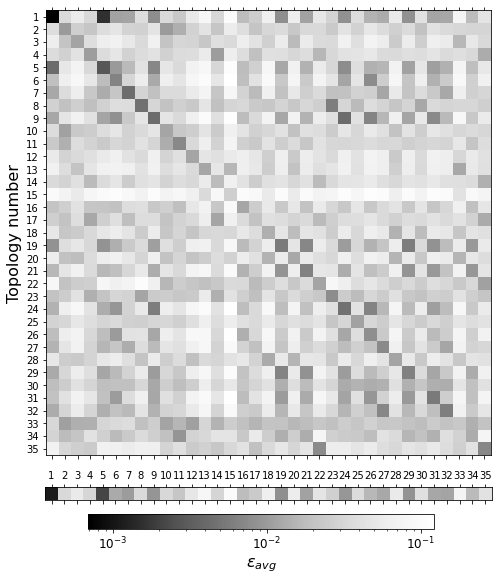

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

PATH = '/Users/babaktaheri/Desktop/OLDF/Single-phase' 
TEST_CASE = '33'

# Load data
Obj_array = np.loadtxt(f"{PATH}/Topology studies/parameters/Matrix_Avg_error_{TEST_CASE}bus.txt")
Inf_array = np.loadtxt(f"{PATH}/Topology studies/parameters/Matrix_Max_error_{TEST_CASE}bus.txt")

# Reshape data
Obj_matrix = Obj_array.reshape(35, 35)
Inf_matrix = Inf_array.reshape(35, 35)

def plot_heatmap_with_vector_log_scale_and_colorbar(matrix, vector, title, cmap='Greys_r'):
    # Ensure no zero or negative values before applying log scale
    matrix = np.where(matrix <= 0, np.nan, matrix)
    vector = np.where(vector <= 0, np.nan, vector)

    # Calculate global min and max values for consistent color scale
    global_min = np.nanmin([np.nanmin(matrix), np.nanmin(vector)])
    global_max = np.nanmax([np.nanmax(matrix), np.nanmax(vector)])
    norm = LogNorm(vmin=global_min, vmax=global_max)

    # Create figure and axes for the heatmap and vector
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [35, 1], 'hspace': 0.14})

    # Plot heatmap
    cax1 = ax1.matshow(matrix, cmap=cmap, norm=norm)
    ax1.set_title(title)
    ax1.set_ylabel("Topology number", fontsize=16)
    ax1.set_xticks(range(0, 35))
    ax1.set_yticks(range(0, 35))
    ax1.set_xticklabels([])
    ax1.set_yticklabels(range(1, 36))

    # Plot vector
    cax2 = ax2.matshow(vector.reshape(1, -1), cmap=cmap, norm=norm, aspect='auto')
    ax2.set_xticks(range(0, 35))
    ax2.set_xticklabels(range(1, 36))
    ax2.set_yticks([])

    # Adjust subplot parameters to minimize gaps
    plt.subplots_adjust(hspace=0.05, bottom=0.2)

    # Create an axes for the colorbar below the vector plot
    cbax = fig.add_axes([0.2, 0.16, 0.6, 0.02]) # [left, bottom, width, height]
    cbar = fig.colorbar(cax1, cax=cbax, orientation='horizontal')
    cbar.set_label('$\\varepsilon_{avg}$', fontsize=16)
    cbar.ax.tick_params(labelsize=12)

    plt.savefig(f"{PATH}/Topology studies/Figs/matrix_vs_vec.eps", format='eps', dpi=100, bbox_inches='tight', pad_inches=0.1)
    plt.show()

# Load the vector just like you did for the matrix
vector = np.loadtxt(f"{PATH}/Topology studies/parameters/LDF_Avg_error_{TEST_CASE}bus.txt")

# Call the function with both the matrix and the vector
plot_heatmap_with_vector_log_scale_and_colorbar(Obj_matrix, vector, f"Average Error Heatmap")


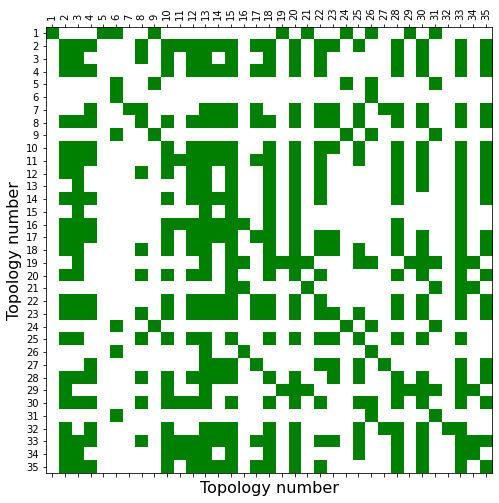

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define PATH and TEST_CASE
PATH = '/Users/babaktaheri/Desktop/OLDF/Single-phase' 
TEST_CASE = '33'

# Load Obj_matrix and vector
Obj_array = np.loadtxt(f"{PATH}/Topology studies/parameters/Matrix_Avg_error_{TEST_CASE}bus.txt")
Obj_matrix = Obj_array.reshape(35, 35)
vector = np.loadtxt(f"{PATH}/Topology studies/parameters/LDF_Avg_error_{TEST_CASE}bus.txt")

def plot_comparison_matrix(matrix, vector, title):
    # Initialize a comparison matrix of the same shape as the input matrix
    comparison_matrix = np.zeros_like(matrix, dtype=bool)
    
    for i in range(matrix.shape[0]):  # For each row
        for m in range(matrix.shape[1]):  # For each column in the row
            # Compare the element of the matrix with the corresponding element in the vector
            comparison_matrix[i, m] = matrix[i, m] < vector[m]
    
    # Define a custom color map: green for True (better performance), white for False
    cmap = ListedColormap(['white', 'green'])

    fig, ax = plt.subplots(figsize=(8, 10))
    cax = ax.matshow(comparison_matrix, cmap=cmap)
    
    ax.set_title(title)
    ax.set_xlabel("Topology number", fontsize=16)
    ax.set_ylabel("Topology number", fontsize=16)
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels(range(1, matrix.shape[1] + 1), rotation=90) 
    ax.set_yticklabels(range(1, matrix.shape[0] + 1))
    
    plt.savefig(f"{PATH}/Topology studies/Figs/Comparison.eps", format='eps', dpi=100, bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_comparison_matrix(Obj_matrix, vector, "Comparison Matrix")
